In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import sys
sys.path.append(str(Path('.').resolve().parents[0].joinpath('code')))
from ppc import get_train_val_test_dfs, red_count_preprocess, full_preprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
## PARAMETERS 
type = 'all_features' # "all_features", "one_feature"
red_thresh = 30
model_type = 'xgboost' # "RF" , 'xgboost'
tuning = False 
rf_params = {'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

xgboost_params =  {'colsample_bytree': 0.3, 
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100}

## Dataset with images unloaded

In [3]:
df_train, df_val, df_test = get_train_val_test_dfs(val_size=.3)
y_train = df_train['target'].apply(int).values
y_val = df_val['target'].apply(int).values
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape

((91637, 9), (32961, 9), (33561, 7), (91637,), (32961,))

## One feature : percentage of red pixels for each image or Multiple features 

In [4]:
if type == 'one_feature' : 
    X_train = red_count_preprocess(df_train, red_thresh=red_thresh)
    X_val = red_count_preprocess(df_val, red_thresh=red_thresh)
    X_train.shape, X_val.shape

elif type == 'all_features' :
    features = [ 'OMS', 'RNA_scope', 'Tabac',  'Alcool', 'Age_diag' ] #, "Sexe'" , 'T','N', 'M'
    data_path = Path('.').resolve().parents[0].joinpath('data')
    train_db_path = str(data_path.joinpath('KORL_avatar_train.csv'))
    X_train = full_preprocess(features, train_db_path, df_train, red_thresh= red_thresh )
    X_val = full_preprocess(features, train_db_path, df_val, red_thresh= red_thresh )
    X_train.shape, y_train.shape, X_val.shape, y_val.shape

# Hyperparameters tuning

In [5]:
if tuning and model_type == 'RF' : 
    random_grid_RF = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 4)] ,
                'max_features': ['auto', 'sqrt'],
                'max_depth': [int(x) for x in np.linspace(3, 50, num = 6)],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False] }

    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    rf_random = GridSearchCV(estimator = rf, param_grid = random_grid_RF, cv = 3, verbose=2, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)

    rf_params  = rf_random.best_params_
    print('Best paramaters : ' , rf_params)

if tuning and model_type == 'xgboost' : 
    random_grid_xgboost = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [50, 100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

    model = XGBClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    model_random = GridSearchCV(estimator = model, param_grid = random_grid_xgboost, cv = 3, verbose=2, n_jobs = -1)
    # Fit the random search model
    model_random.fit(X_train, y_train)

    xgboost_params  = model_random.best_params_
    print('Best paramaters : ' , xgboost_params)

# Train

In [6]:
if model_type == 'RF' : 
    model = RandomForestClassifier(n_estimators=rf_params ['n_estimators'],
                                min_samples_split=rf_params ['min_samples_split'],
                                min_samples_leaf=rf_params ['min_samples_leaf'],
                                max_features=rf_params ['max_features'],
                                max_depth=rf_params ['max_depth'],
                                bootstrap=rf_params ['bootstrap'])
elif model_type == 'xgboost' : 
    model = XGBClassifier(max_depth=xgboost_params ['max_depth'],
                        learning_rate=xgboost_params ['learning_rate'],
                        n_estimators=xgboost_params ['n_estimators'],
                        colsample_bytree=xgboost_params ['colsample_bytree'])
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_val, y_val)

[21:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.9999781747547388, 0.37996420011528775)

# Performance of the model

In [7]:
# Aggregate to see result per patient
df_val['pred'] = model.predict(X_val)
n_correct = 0
n_total = 0
for i, gb_df in df_val.groupby('patient'):
    target = gb_df['target'].values[0]
    pred = gb_df['pred'].value_counts().index[0]
    n_correct += target == pred
    n_total += 1
n_correct / n_total, n_correct, n_total

(0.3333333333333333, 4, 12)

# Feature importance

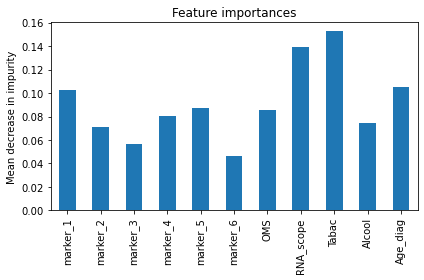

In [8]:
fig, ax = plt.subplots()
if model_type == 'RF' : 
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    model_importances = pd.Series( model.feature_importances_, index=X_train.columns)
    model_importances.plot.bar(yerr=std, ax=ax)
    
if model_type == 'xgboost' : 
    model_importances = pd.Series(model.feature_importances_, index = X_train.columns)
    model_importances.plot.bar( ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()